# Coursework 1
## Information Visualization

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from squarify import plot

## Task A

In [3]:
df = pd.read_csv("IV cw 1 2022 dataset.csv", parse_dates=["Usage date"])
df = df.set_index("Usage date")

# Line chart: Monthly spending
monthly_total = df.groupby(pd.Grouper(freq='M')).sum("Spend to Date")
monthly_individual = df.groupby("Project ID").apply(lambda x: x.groupby(pd.Grouper(freq='M')).sum("Spend to Date")).unstack(0).droplevel(0, axis=1)
monthly_individual = monthly_individual[monthly_individual.sum().sort_values(ascending=False).index[:3]]

# Stacked bar chart: Cost of resources per project
prices_per_resource = df.groupby(["Project ID", "ResourceType.2.1", "Type"]).sum("Spend to Date")
prices_per_resource.index = pd.MultiIndex.from_tuples(map(lambda x: (x[0], '/'.join(x[1:])), prices_per_resource.index), names=['Project ID', 'Resource'])
prices_per_resource = prices_per_resource.unstack(0).droplevel(0, axis=1).fillna(0)
prices_per_resource = prices_per_resource[prices_per_resource.sum().sort_values(ascending=False).index[:len(prices_per_resource.columns)//2]]

# Boxplot: Number of resources in each resource group
resource_group_sizes = df.groupby(["ResourceGroupName"]).count().ResourceId.rename("Resource count per group").sort_values(ascending=False)

# Tree map: Cost per resource type
resource_cost = df.groupby(["Type"]).sum("Spend to Date").squeeze()
resource_cost = resource_cost[resource_cost > 0].sort_values(ascending=False)

C:\Users\Hackerman\AppData\Local\Temp\ipykernel_15896\300163420.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
C:\Users\Hackerman\AppData\Local\Temp\ipykernel_15896\300163420.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


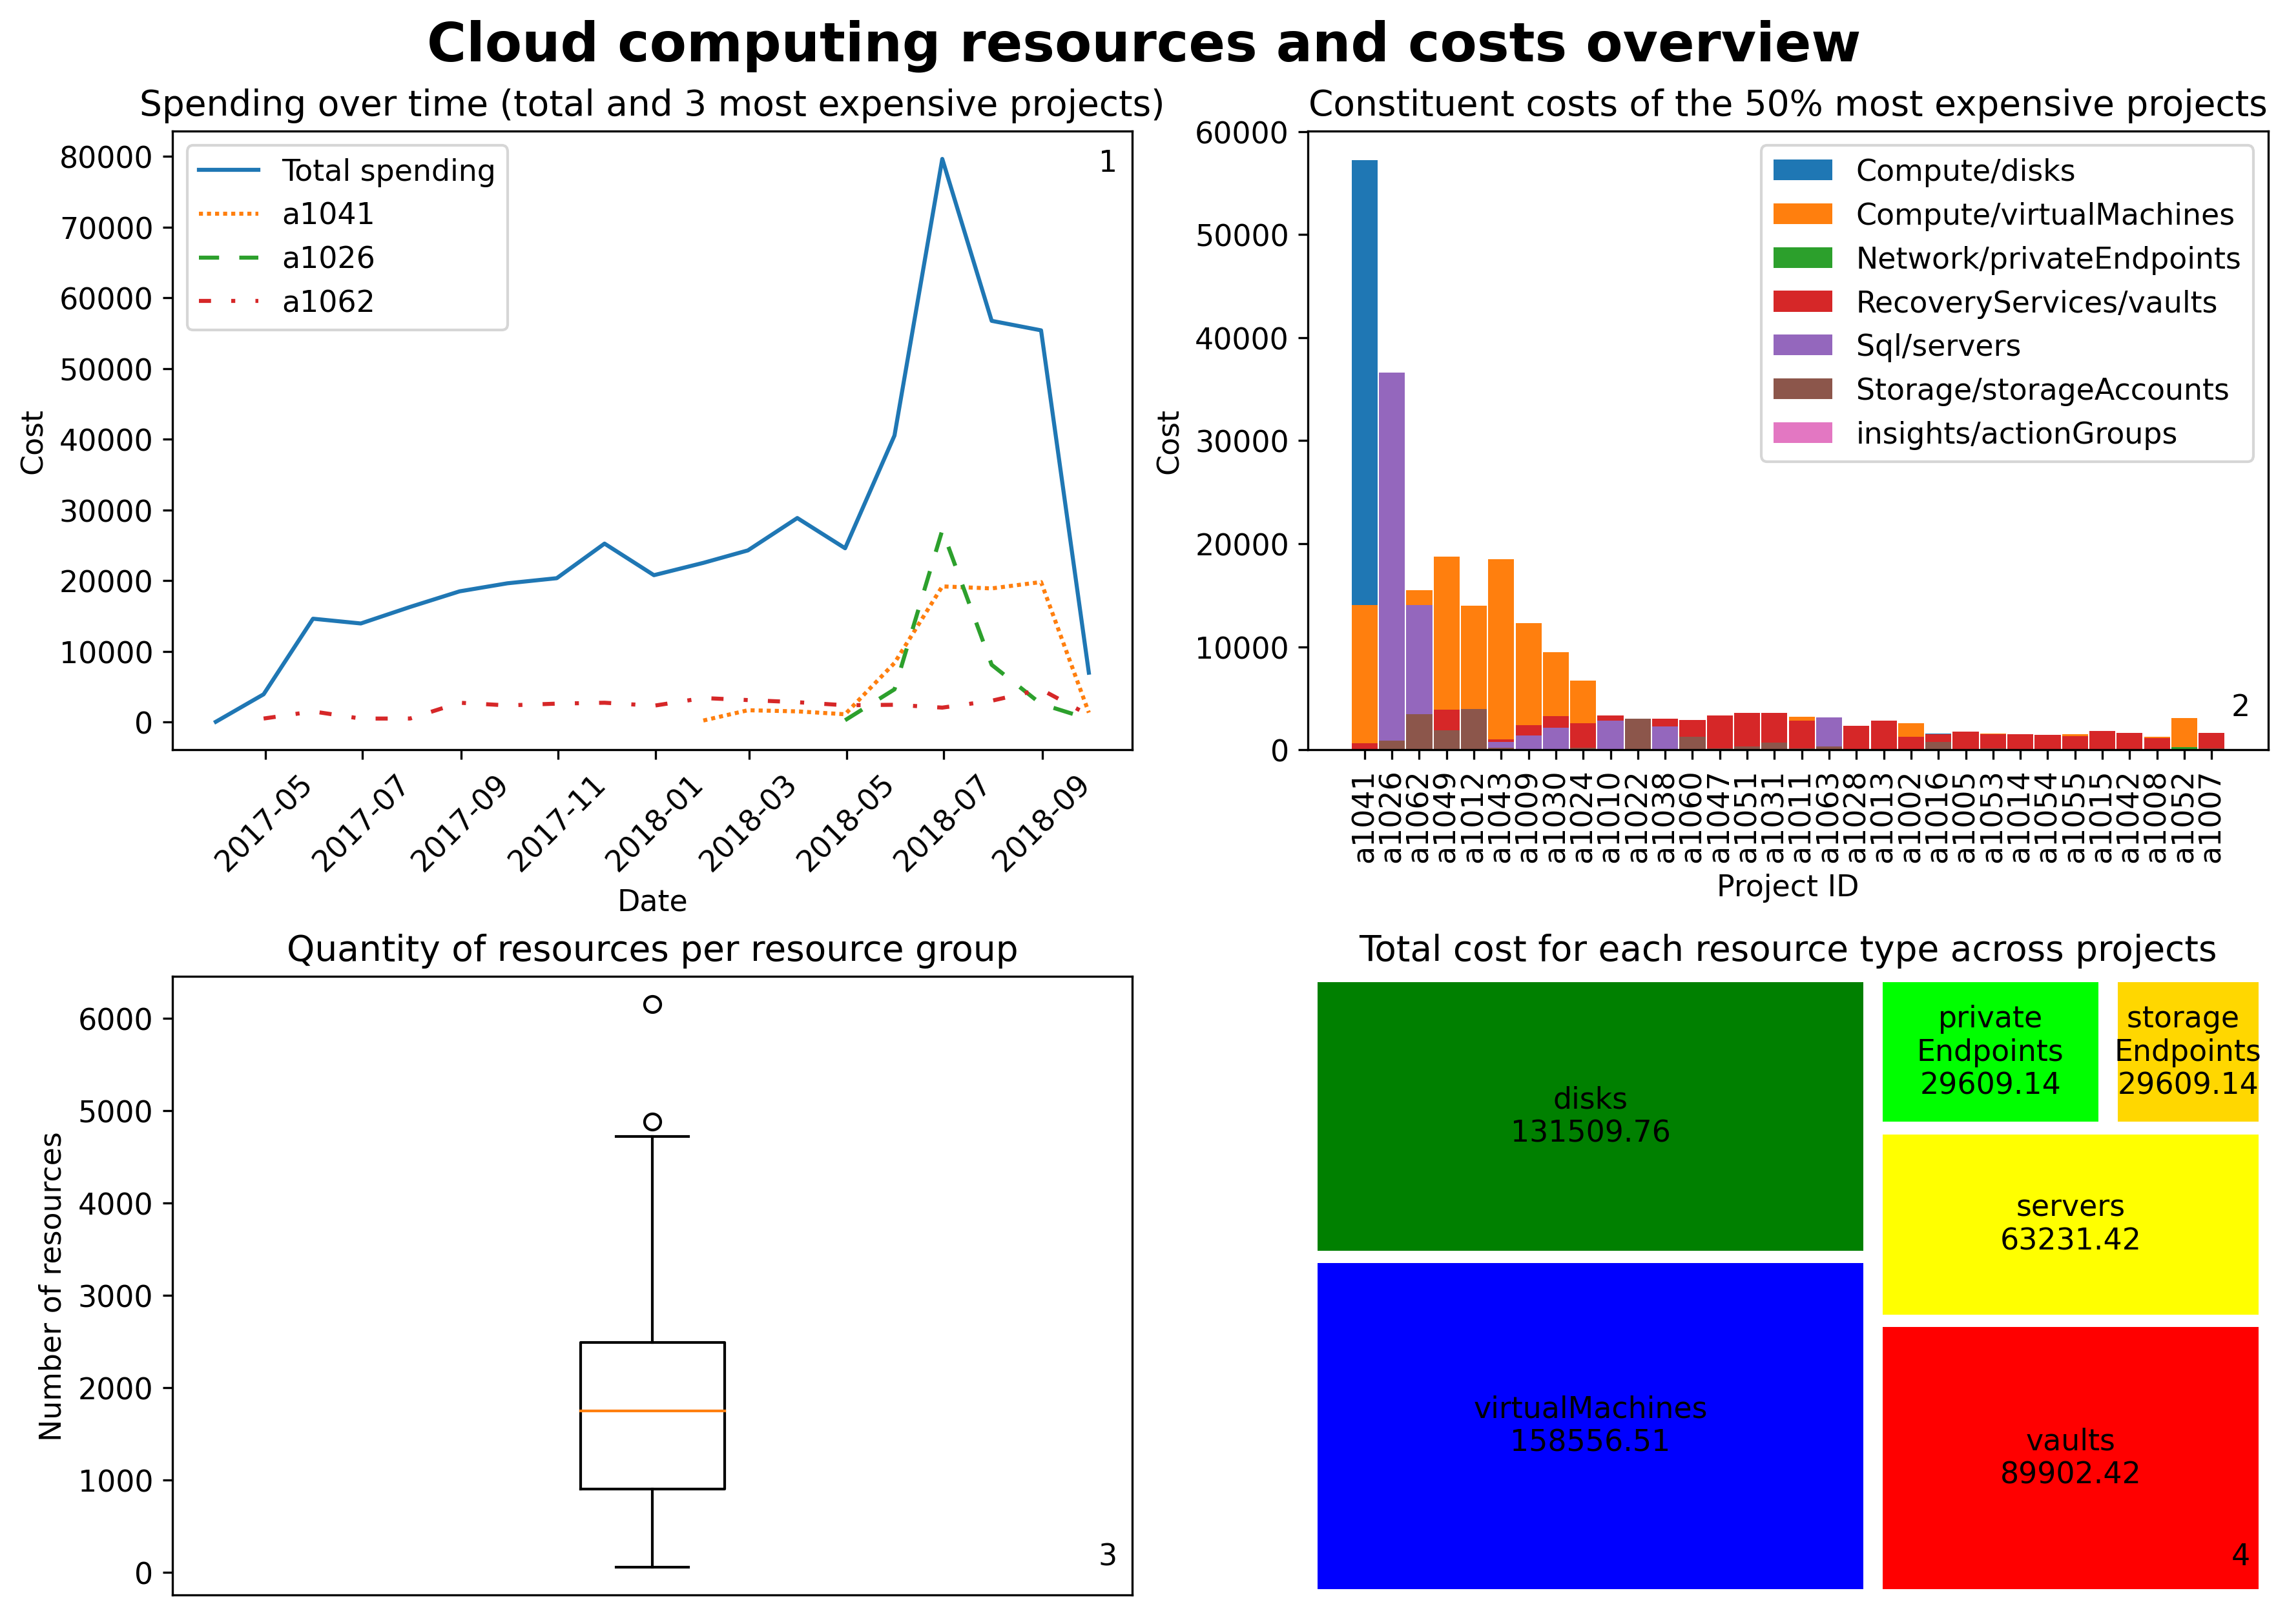

In [8]:
fig, axs = plt.subplots(2, 2, figsize=(11.69, 8.27), dpi=300, constrained_layout=True)
matplotlib.rc('font', size=11)

ax = axs[0, 0]
styles = [(0, (1, 1)), (0, (5, 5)), (0, (3, 5, 1, 5))]
ax.plot(monthly_total, label="Total spending")
for ((label, line), style) in zip(monthly_individual.items(), styles):
    ax.plot(line, linestyle=style, label=label)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_xlabel("Date")
ax.set_ylabel("Cost")
ax.set_title("Spending over time (total and 3 most expensive projects)")
fig.text(0.48, 0.9, '1')
ax.legend()

ax = axs[0, 1]
for label, data in prices_per_resource.iterrows():
    ax.bar(prices_per_resource.columns, data, 0.95, label=label)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_xlabel("Project ID")
ax.set_ylabel("Cost")
ax.set_title("Constituent costs of the 50% most expensive projects")
fig.text(0.98, 0.56, '2')
ax.legend()

ax = axs[1, 0]
ax.boxplot(resource_group_sizes)
ax.set_xticks([])
ax.set_ylabel("Number of resources")
ax.set_title("Quantity of resources per resource group")
fig.text(0.48, 0.03, '3')

labels = [f"{l}\n{c:.2f}" for l, c in zip(resource_cost.index, resource_cost)]
labels[-2] = labels[-2][:7] + '\n' + labels[-2][7:]
labels[-1] = labels[-1][:7] + ' ' + labels[-2][7:]
colors = ['b', 'g', 'r', 'yellow', 'lime', 'gold']
plot(sizes=resource_cost.to_numpy(), label=labels, color=colors, pad=1)
plt.axis("off")
plt.title("Total cost for each resource type across projects")
fig.text(0.98, 0.03, '4')

plt.suptitle("Cloud computing resources and costs overview", weight='bold', fontsize=20)
plt.show()